In [1]:
!pip install plotly

In [2]:
import plotly.express as px
import plotly.graph_objects as go

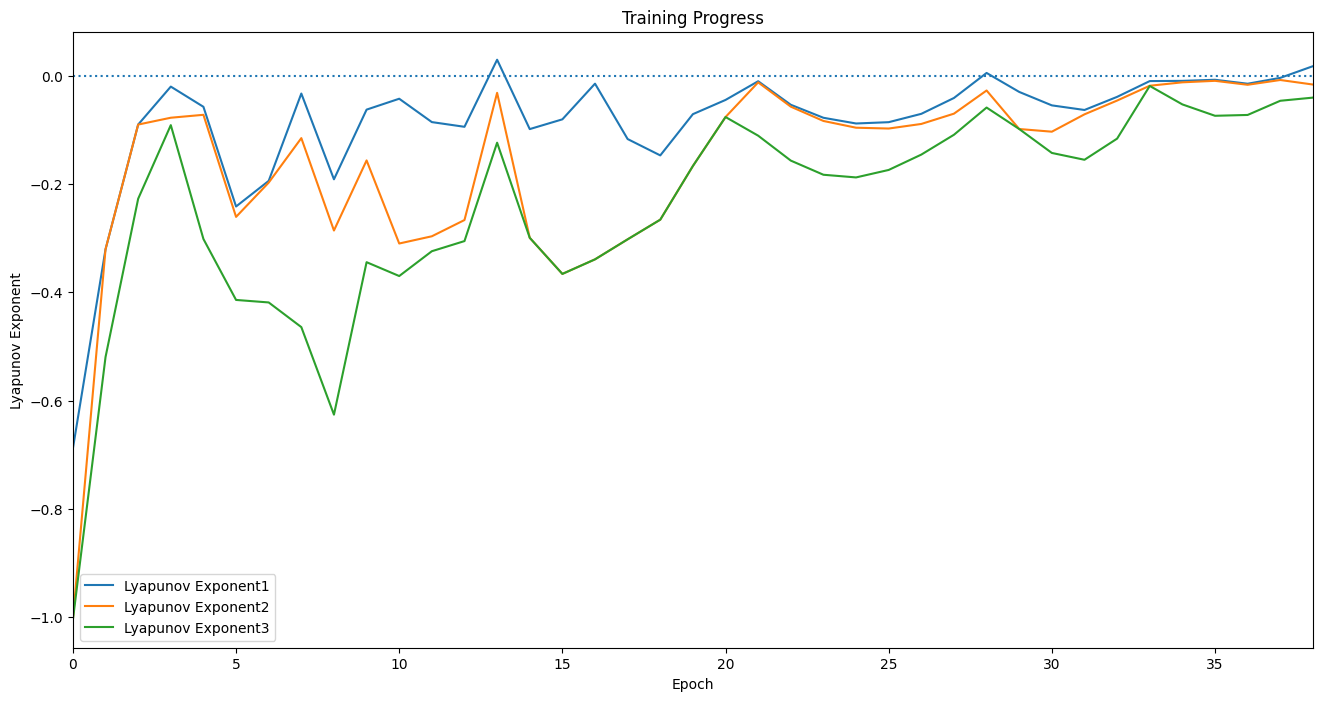

Final Lyapunov Exponent 1: 0.03510743
Final Lyapunov Exponent 2: -0.03267419
Final Lyapunov Exponent 3: -0.08097665
0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


/var/folders/ny/tr438r955874mzb5kpjdc_680000gn/T/ipykernel_18165/1575157807.py:240: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')  # You can choose a different colormap
/var/folders/ny/tr438r955874mzb5kpjdc_680000gn/T/ipykernel_18165/1575157807.py:255: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


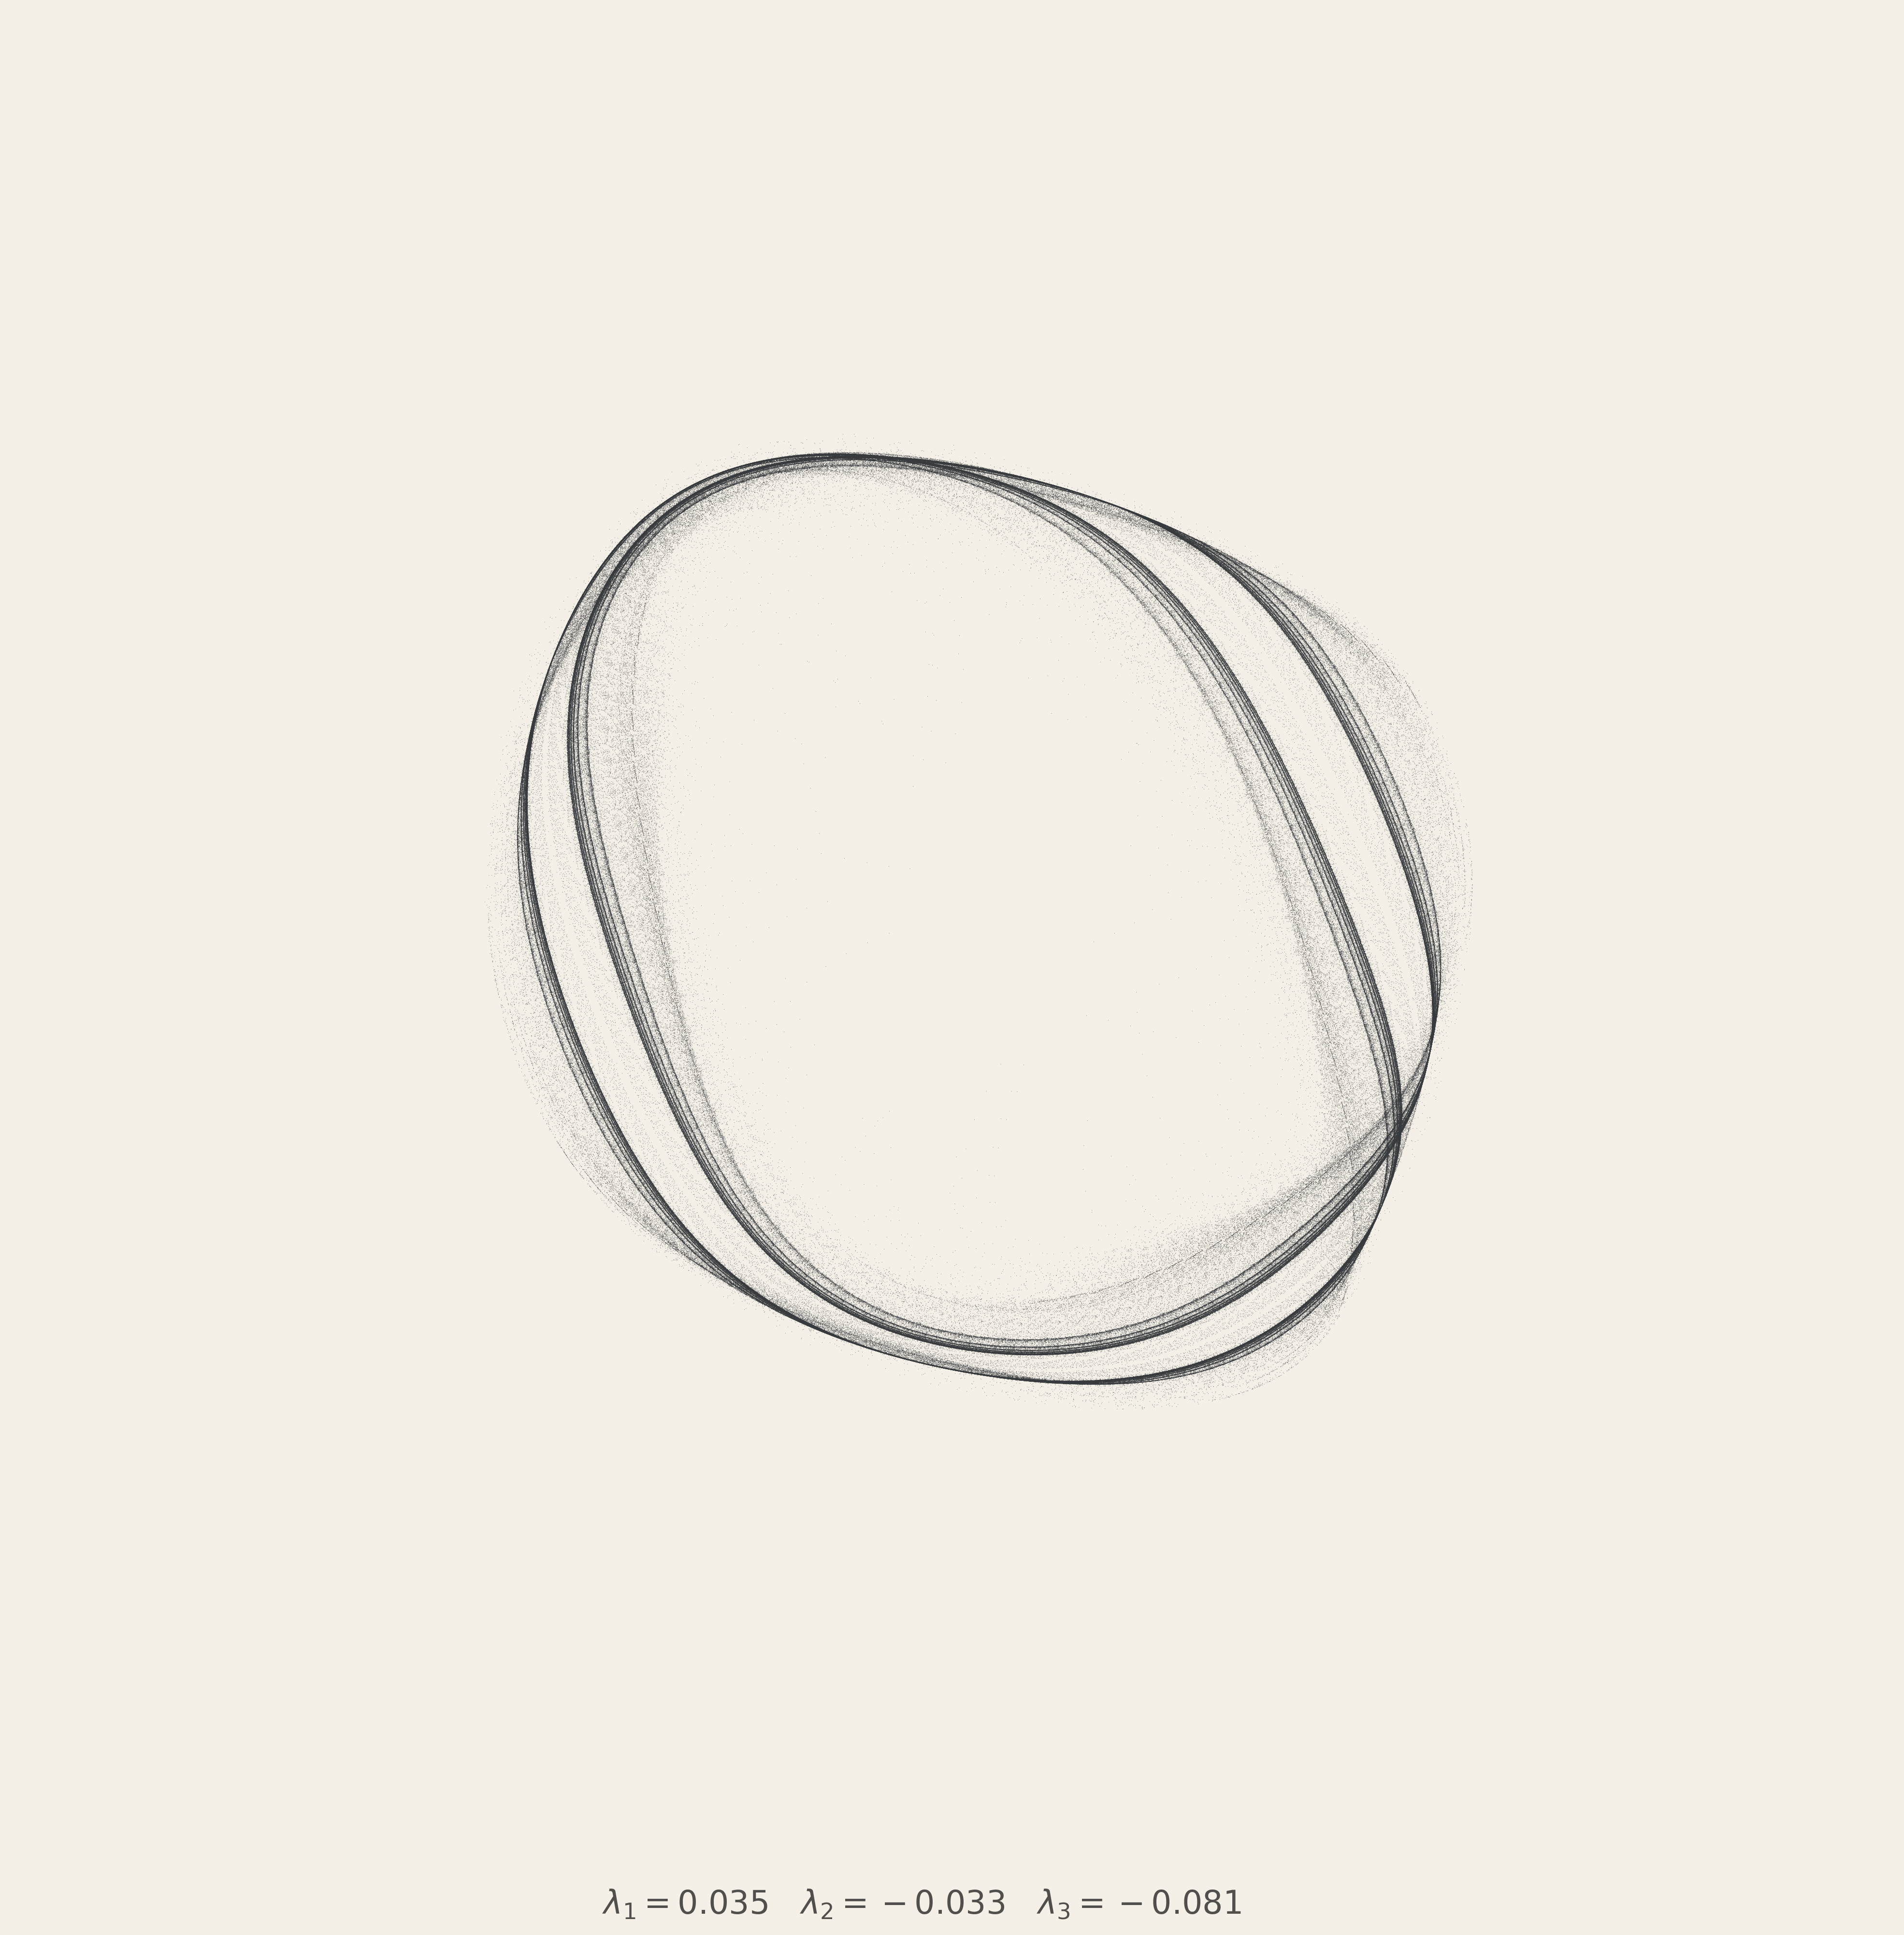

In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd.functional import jacobian
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd

# Definition of a feedforward neural network
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.Tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.Tanh(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = 3
hidden_size = 10
output_size = 3
num_steps = 300
epochs = 100
learning_rate = 0.1
num_chaotic_attractors = 1

k = 0
while (k <num_chaotic_attractors):

  # Model and initial condition
  model = FeedForward(input_size, hidden_size, output_size)
  initial_condition = torch.rand((1, input_size))

  # Lyapunov exponent plot
  lyapunov_exponent_plot = np.zeros(epochs)
  lyapunov_exponent1_plot = np.zeros(epochs)
  lyapunov_exponent2_plot = np.zeros(epochs)
  lyapunov_exponent3_plot = np.zeros(epochs)

  # Input trajectory
  input_trajectory_list = []
  lyapunovs_list_mean = torch.zeros(epochs,input_size)

  # Choose optimizer
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Training loop
  for epoch in range(epochs):
      optimizer.zero_grad()
      model.train()

      # Initial condition
      input = initial_condition.clone().requires_grad_(True)

      # Lyapunov exponent lists
      eigenvalues_sum = torch.zeros(num_steps, requires_grad=True)

      eigenvalues_prod = torch.ones(num_steps, requires_grad=True)

      lyapunovs_sum = torch.zeros(num_steps, requires_grad=True)

      lyapunov_max = torch.zeros(num_steps, requires_grad=True)

      lyapunovs_list = torch.zeros(input_size)

      lyapunovs_1_list = torch.zeros(num_steps, requires_grad=True)

      lyapunovs_2_list = torch.zeros(num_steps, requires_grad=True)

      lyapunovs_3_list = torch.zeros(num_steps, requires_grad=True)

      for i in range(num_steps):
          # Compute Jacobian matrix for the original trajectory
          jacobian_matrix = jacobian(model, input, create_graph=True)
          jacobian_matrix = torch.reshape(jacobian_matrix.clone(), (input_size, input_size))

          # Calculate Eigenvalues
          if torch.isnan(jacobian_matrix).any() or torch.isinf(jacobian_matrix).any():
              # Handle NaN or Inf values in the Jacobian matrix
              print("Jacobian matrix contains NaN or Inf values. Training stopped.")
              epoch = epochs + 1

          eigenvalues = (torch.linalg.eigvals(jacobian_matrix))

          lyapunovs, ind = torch.sort(torch.log(torch.abs(eigenvalues)), descending=True)

          lyapunovs_1 = lyapunovs[0]
          lyapunovs_2 = lyapunovs[1]
          lyapunovs_3 = lyapunovs[2]

          # Update the Lyapunov sum
          eigenvalues_sum = torch.cat((eigenvalues_sum, torch.abs(torch.sum(eigenvalues)).view(1)))

          eigenvalues_prod = torch.cat((eigenvalues_prod, torch.prod(torch.abs(eigenvalues)).view(1)))

          lyapunov_max = torch.cat((lyapunov_max, torch.max(lyapunovs).view(1)))

          lyapunovs_sum = torch.cat((lyapunovs_sum, torch.sum(lyapunovs).view(1)))

          lyapunovs_list+=(lyapunovs)/num_steps

          lyapunovs_1_list = torch.cat((lyapunovs_1_list,(lyapunovs_1).view(1)))

          lyapunovs_2_list = torch.cat((lyapunovs_2_list,(lyapunovs_2).view(1)))

          lyapunovs_3_list = torch.cat((lyapunovs_3_list,(lyapunovs_3).view(1)))

          # Save the input vector to the trajectory
          input_trajectory_list.append(input.detach().numpy().squeeze())

          # Update the trajectory
          input = model(input)

      # Averages of eigenvalues and Lyapunov exponents

      eigenvalues_sum_mean = torch.mean(eigenvalues_sum) # Mean over steps of the sum of the eigenvalues of the jacobian

      eigenvalues_prod_mean = torch.mean(eigenvalues_prod) # mean over steps of the product od the eigenvalues of the jacobian

      lyapunov_exponent = torch.mean(lyapunov_max) # Mean over the logarithm of the absolute value of the biggest eigenvalue (in module) of the jacobian (Biggest Lyapunov Exponent)

      lyapunov_sum_mean = torch.mean(lyapunovs_sum) # Mean over the sum of the lyapunov exponents

      lyapunovs_list_mean[epoch] = (lyapunovs_list) # Mean values of the lyapunov exponents for every epoch

      lyapunovs_1_list_mean = torch.mean(lyapunovs_1_list)

      lyapunovs_2_list_mean = torch.mean(lyapunovs_2_list)

      lyapunovs_3_list_mean = torch.mean(lyapunovs_3_list)

      print(lyapunovs_1_list_mean)
      print(lyapunovs_2_list_mean)
      print(lyapunovs_3_list_mean)
      # alpha, bet and gamma are the parameters that regulate the loss
      alpha = - 0.6
      beta = + 0.0
      gamma = + 0.2


      # Define the loss
      loss = - lyapunov_sum_mean

      loss = - lyapunov_sum_mean
      + alpha * (lyapunovs_1_list_mean)
      + beta * torch.abs(lyapunovs_2_list_mean)
      + gamma * torch.abs(lyapunovs_3_list_mean)
      print("Loss =",loss)
      
      # Store  Lyapunov exponent
      lyapunov_exponent_plot[epoch] = lyapunov_exponent.item()
      lyapunov_exponent1_plot[epoch] = lyapunovs_1_list_mean.item()
      lyapunov_exponent2_plot[epoch] = lyapunovs_2_list_mean.item()
      lyapunov_exponent3_plot[epoch] = lyapunovs_3_list_mean.item()

      # plot the Lyapunov exponent over time
      if epoch > 0:
        clear_output(wait=True)
        plt.figure(figsize=(16, 8))
        plt.axhline(y = 0.0, linestyle = 'dotted')  # specifying horizontal line type
        plt.plot(lyapunov_exponent1_plot, label='Lyapunov Exponent1')
        plt.plot(lyapunov_exponent2_plot, label='Lyapunov Exponent2')
        plt.plot(lyapunov_exponent3_plot, label='Lyapunov Exponent3')
        plt.xlabel('Epoch')
        plt.ylabel('Lyapunov Exponent')
        plt.title('Training Progress')
        plt.legend()
        plt.xlim((0, epoch))
        plt.show()
      
      if (lyapunovs_1_list_mean > 0.0) and ((lyapunovs_1_list_mean + lyapunovs_2_list_mean) > 0.0) and ( (lyapunovs_1_list_mean + lyapunovs_2_list_mean + lyapunovs_3_list_mean) < 0.0)and ( torch.abs(lyapunovs_1_list_mean/lyapunovs_3_list_mean) > 0.0):
       break

      # Learning Step
      loss.backward()
      optimizer.step()

  # Plot of the final point
  clear_output(wait=True)
  plt.figure(figsize=(16, 8))
  plt.axhline(y = 0.0, linestyle = 'dotted')  # specifying horizontal line type
  plt.plot(lyapunov_exponent1_plot, label='Lyapunov Exponent1')
  plt.plot(lyapunov_exponent2_plot, label='Lyapunov Exponent2')
  plt.plot(lyapunov_exponent3_plot, label='Lyapunov Exponent3')
  plt.xlabel('Epoch')
  plt.ylabel('Lyapunov Exponent')
  plt.title('Training Progress')
  plt.legend()
  plt.xlim((0, epoch))
  plt.show()

  # Check the final Lyapunov exponent
  X = np.reshape(lyapunovs_list_mean.detach().numpy(), (epochs, input_size)).T

  print("Final Lyapunov Exponent 1:", X[0,epoch])
  print("Final Lyapunov Exponent 2:", X[1,epoch])
  print("Final Lyapunov Exponent 3:", X[2,epoch])

  # Convert input trajectory list to a numpy array
  input_trajectory_array = np.array(input_trajectory_list)

  #---------------------------3D scatter Plot For Final Lyapunov---------------------------#
  if(X[0,epoch]>0):
    # Initial condition
    num_initial_conditions = 1000
    len_examples = 1000
    input_example_trajectory_list =[]

    for j in range(num_initial_conditions):
        input_example = torch.rand((1, input_size)) * 12.0 - 6.0
        if i*j%100 ==0:
         print((j/num_initial_conditions)*100,'%')
        for i in range(len_examples):
            # Save the input vector to the trajectory
            if (i>40):
             input_example_trajectory_list.append(input_example.detach().numpy().squeeze())

            # Update the trajectory
            input_example = model(input_example)

    #Convert input trajectory list to a numpy array
    input_example_trajectory_array = np.array(input_example_trajectory_list)


    # Normalize the sequence index to [0, 1] for colormap mapping
    normalized_sequence_index = np.arange(len_examples * num_initial_conditions) / (len_examples * num_initial_conditions)
#---------------------------3D scatter Plot---------------------------#
    # Convert input trajectory list to a numpy array
    input_trajectory_array = np.array(input_trajectory_list)

    # Create a colormap
    cmap = cm.get_cmap('bwr')  # You can choose a different colormap

    # Normalize the sequence index to [0, 1] for colormap mapping
    normalized_sequence_index = (input_example_trajectory_array[:, 2]) / len(input_example_trajectory_array[:, 2])

    # Create a 3D plot
    fig = plt.figure(figsize = plt.figaspect(1)*3.5, dpi = 300) # Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
    ax = fig.add_subplot(projection = '3d')
    ax.set_box_aspect(aspect = (1, 1, 1))

    # Set plot background color
    fig.set_facecolor("#f4f0e8")
    ax.set_facecolor("#f4f0e8")

    # Plot the 3D trajectory with color-coded points
    scatter = ax.scatter(
        input_example_trajectory_array[:, 0],
        input_example_trajectory_array[:, 1],
        input_example_trajectory_array[:, 2],
        c = "#383b3e",  # Assign color
        cmap=cmap,
        s=0.05,
        alpha = 1.0,
        linewidths= 0.0001,
        label=''
    )

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.axis('off') # You can choose to plot or not the axis
    ax.set_title('')


    # Adjust the view angle (azimuthal angle and elevation angle)
    ax.view_init(azim=100, elev=0)  # Adjust these angles as needed

    # Add legend
    #ax.legend()

    # Add title with LaTeX style at the bottom of the plot
    plt.figtext(0.5, 0.10, r'$\lambda_1 = {:.2g}\quad \lambda_2 = {:.2g} \quad \lambda_3 = {:.2g}$'.format(X[0][int(epoch)], X[1][int(epoch)], X[2][int(epoch)]), ha='center', fontsize=16,fontweight='light', fontstyle='italic', fontname='DejaVu Sans Mono', alpha=0.67)

    # Show the plot
    plt.show()
    # Filename and filesave

    filename1 = 'Strange_Attractor_' + str(X[0,epoch]) +'.pdf'
    filename2 = 'Strange_Attractor_' + str(X[0,epoch]) +'.png'
    filename3 = 'Strange_Attractor_' + str(X[0,epoch]) +'.pth'
    #fig.savefig('my_plot.eps', dpi=300, format ='eps')
    #fig.savefig('my_plot.pdf', dpi=300, format ='pdf')
    #fig.savefig(filename1, dpi=300, format ='pdf') 
    fig.savefig(filename2, dpi=900, format ='png')
    torch.save(model.state_dict(),filename3)
    k+=1

In [5]:
import matplotlib.font_manager
print([f.name for f in matplotlib.font_manager.fontManager.ttflist])

['cmex10', 'STIXGeneral', 'DejaVu Serif Display', 'STIXSizeThreeSym', 'cmtt10', 'cmmi10', 'DejaVu Sans', 'STIXGeneral', 'STIXNonUnicode', 'cmb10', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'STIXSizeFourSym', 'DejaVu Sans', 'DejaVu Sans Mono', 'STIXNonUnicode', 'DejaVu Sans', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'cmss10', 'DejaVu Sans Display', 'STIXGeneral', 'STIXGeneral', 'DejaVu Sans Mono', 'STIXSizeOneSym', 'STIXNonUnicode', 'DejaVu Sans', 'STIXSizeTwoSym', 'cmr10', 'cmsy10', 'STIXSizeOneSym', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'STIXNonUnicode', 'STIXSizeFiveSym', 'STIXSizeFourSym', 'DejaVu Serif', 'Marion', 'Apple Braille', 'Hiragino Sans', 'Sukhumvit Set', 'Noto Sans Avestan', 'PingFang HK', 'Heiti TC', 'Hiragino Sans GB', 'DecoType Naskh', 'Hiragino Mincho ProN', 'Times', 'Bodoni 72 Oldstyle', 'Noto Sans Masaram Gondi', 'Didot', 'Wingdings', 'Noto Sans Mende Kikakui', 'Seravek', 'Hiragino Sans', 'Andale Mono', 'Party LET', 'Georgia', 'Noto Sans Miao', 'Arial Narrow', 

/var/folders/ny/tr438r955874mzb5kpjdc_680000gn/T/ipykernel_18165/72626672.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')  # You can choose a different colormap
/var/folders/ny/tr438r955874mzb5kpjdc_680000gn/T/ipykernel_18165/72626672.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


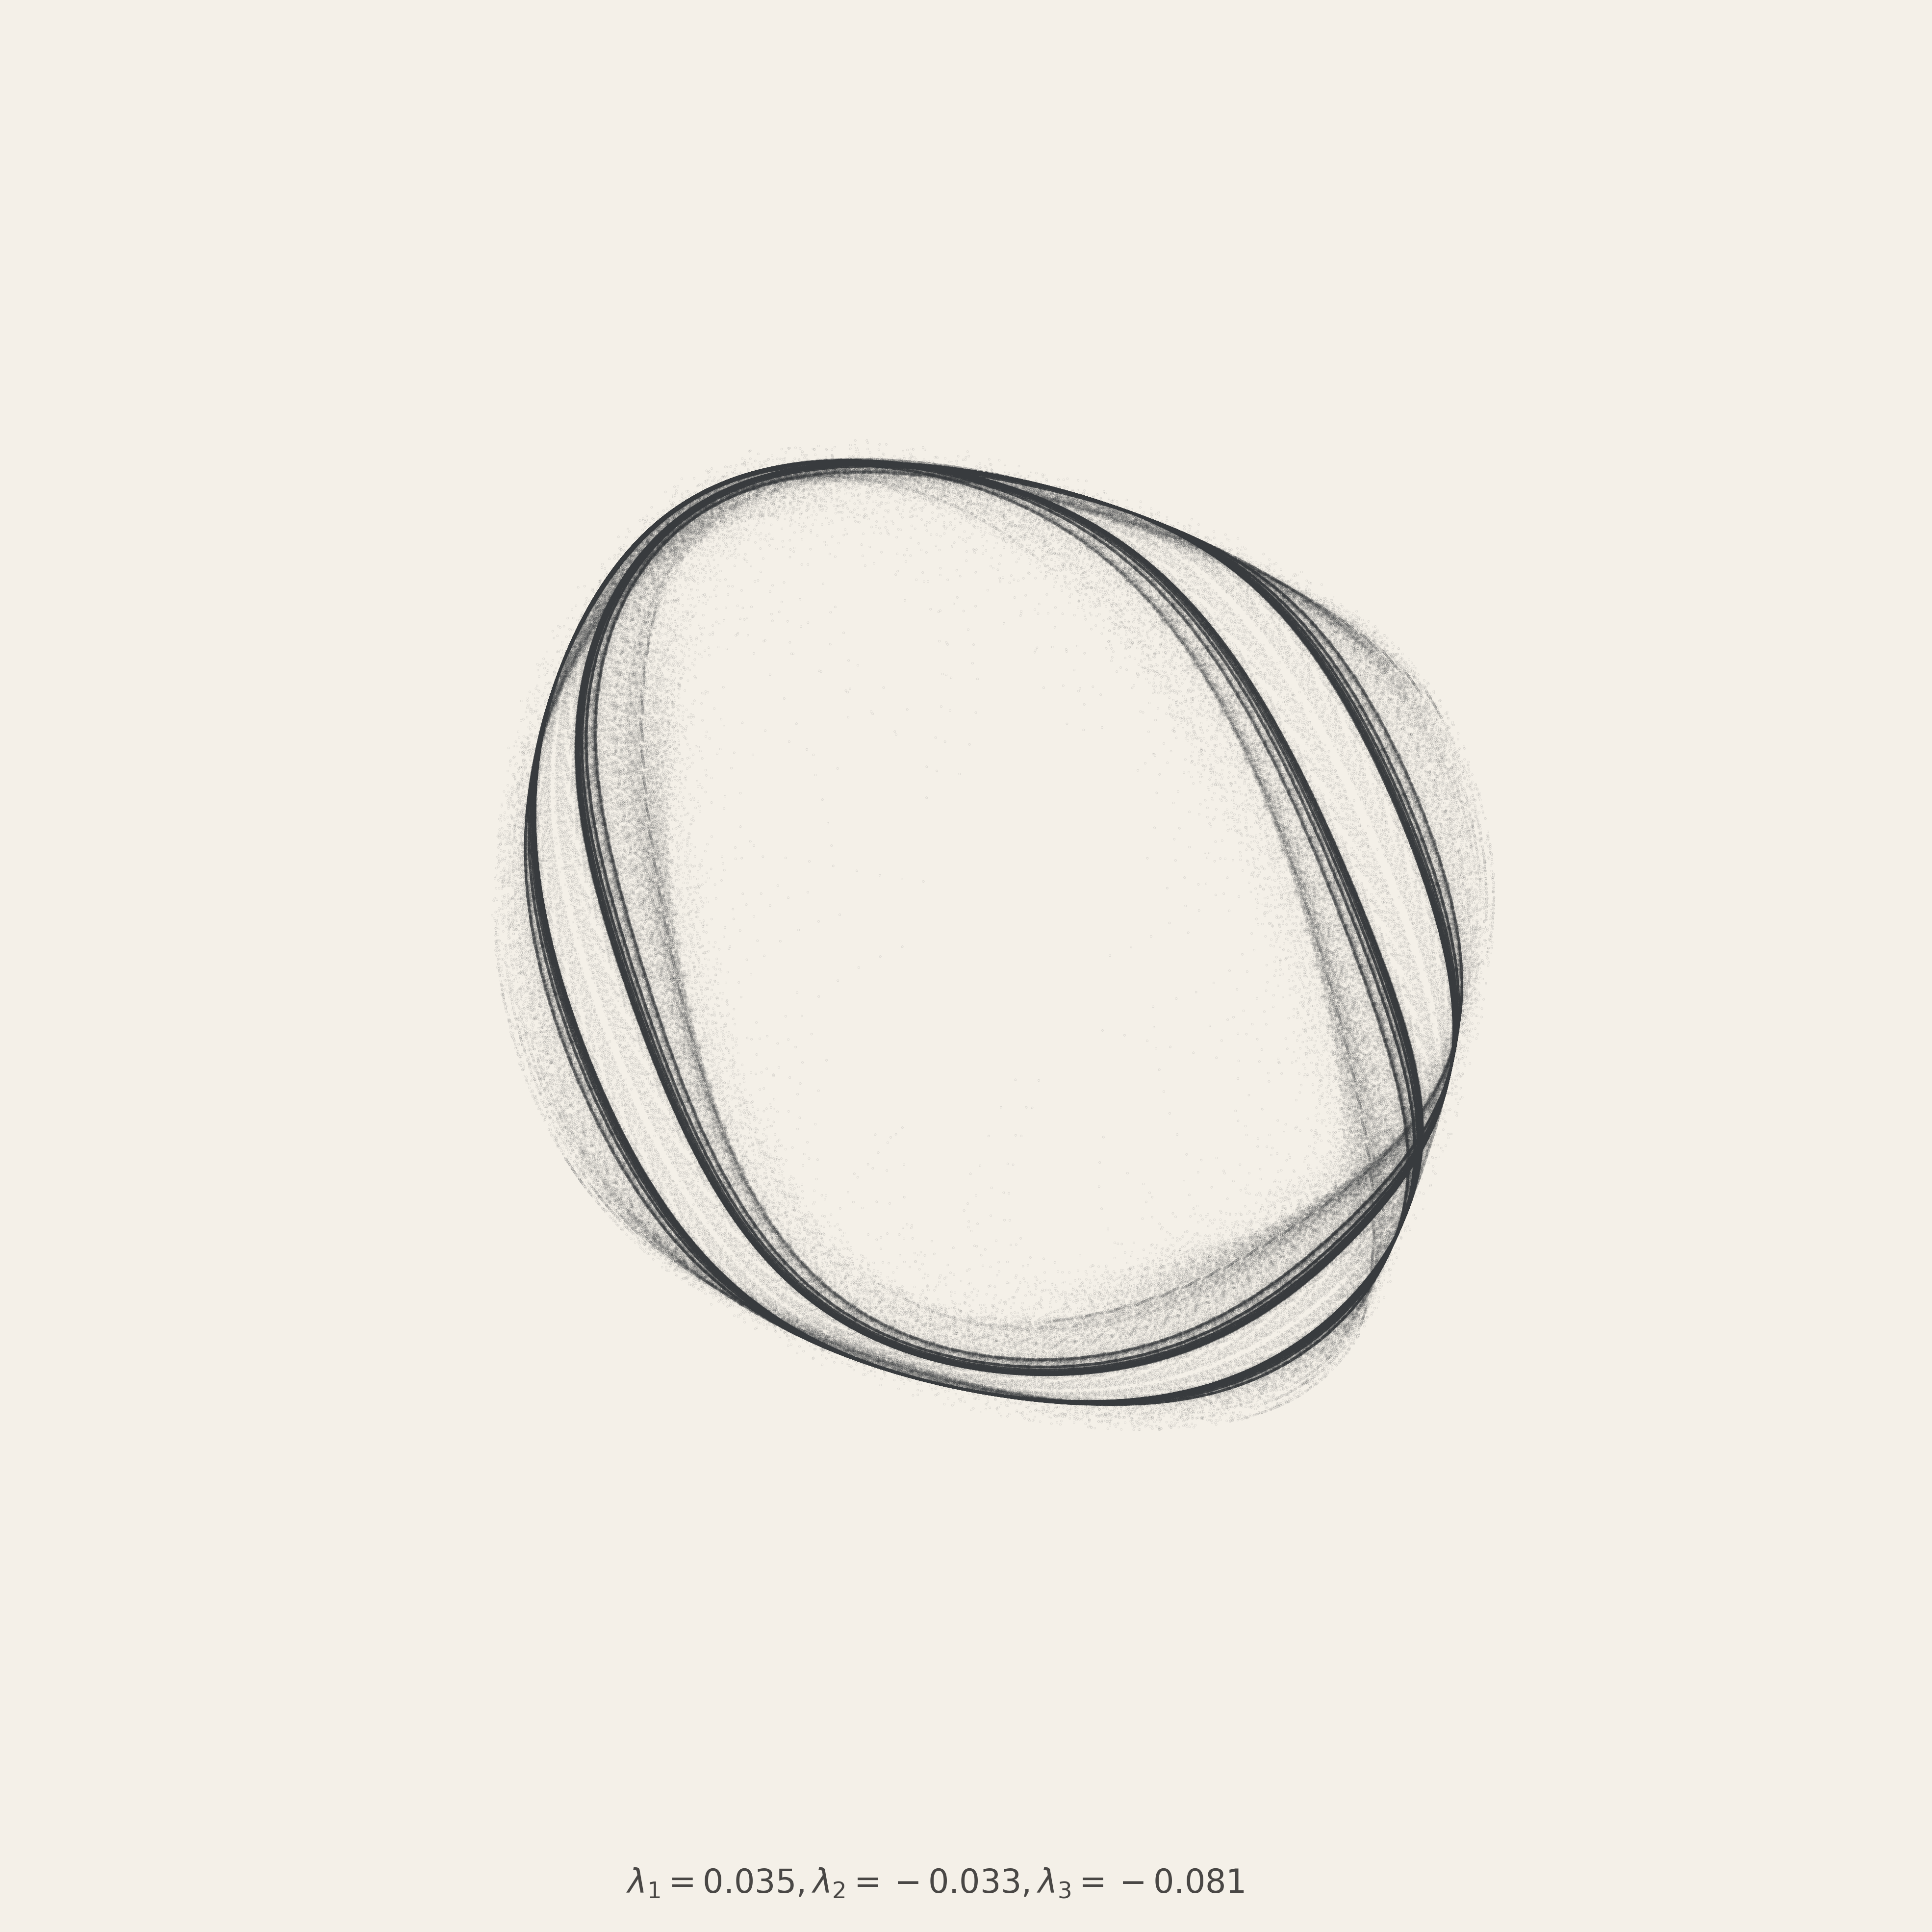

In [6]:
#---------------------------3D scatter Plot---------------------------#
# Convert input trajectory list to a numpy array
input_trajectory_array = np.array(input_trajectory_list)


# Create a colormap
cmap = cm.get_cmap('bwr')  # You can choose a different colormap

# Normalize the sequence index to [0, 1] for colormap mapping
normalized_sequence_index = (input_example_trajectory_array[:, 2])/len(input_example_trajectory_array[:, 2])

# Create a 3D plot
fig = plt.figure(figsize=plt.figaspect(1)*3.5, dpi=300) # Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect=(1, 1, 1))

# Set plot background color
fig.set_facecolor("#f4f0e8")
ax.set_facecolor("#f4f0e8")


# Plot the 3D trajectory with color-coded points
scatter = ax.scatter(
    input_example_trajectory_array[:, 0],
    input_example_trajectory_array[:, 1],
    input_example_trajectory_array[:, 2],
    c = "#383b3e",  # Assign color
    cmap=cmap,
    marker='.',
    s=0.01,
    alpha =0.5,
    label=''
)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis('off') # You can choose to plot or not the axis
ax.set_title('')


# Adjust the view angle (azimuthal angle and elevation angle)
ax.view_init(azim=100, elev=0)  # Adjust these angles as needed

# Add legend
#ax.legend()


# Add title with LaTeX style at the bottom of the plot
plt.figtext(0.5, 0.12, r'$\lambda_1 = {:.3f}, \lambda_2 = {:.3f}, \lambda_3 = {:.3f}$'.format(X[0][int(epoch)], X[1][int(epoch)], X[2][int(epoch)]), ha='center', fontsize=16,fontweight='light', fontstyle='italic', fontname='DejaVu Sans Mono', alpha=0.7)


# Show the plot
plt.show()
# Filename and filesave
#filename = 'Strange_Attractor_' + str(k) +'.pdf'
#fig.savefig('my_plot.eps', dpi=300, format ='eps')
#fig.savefig('my_plot.pdf', dpi=300, format ='pdf')
#fig.savefig(filename, dpi=300, format ='pdf')

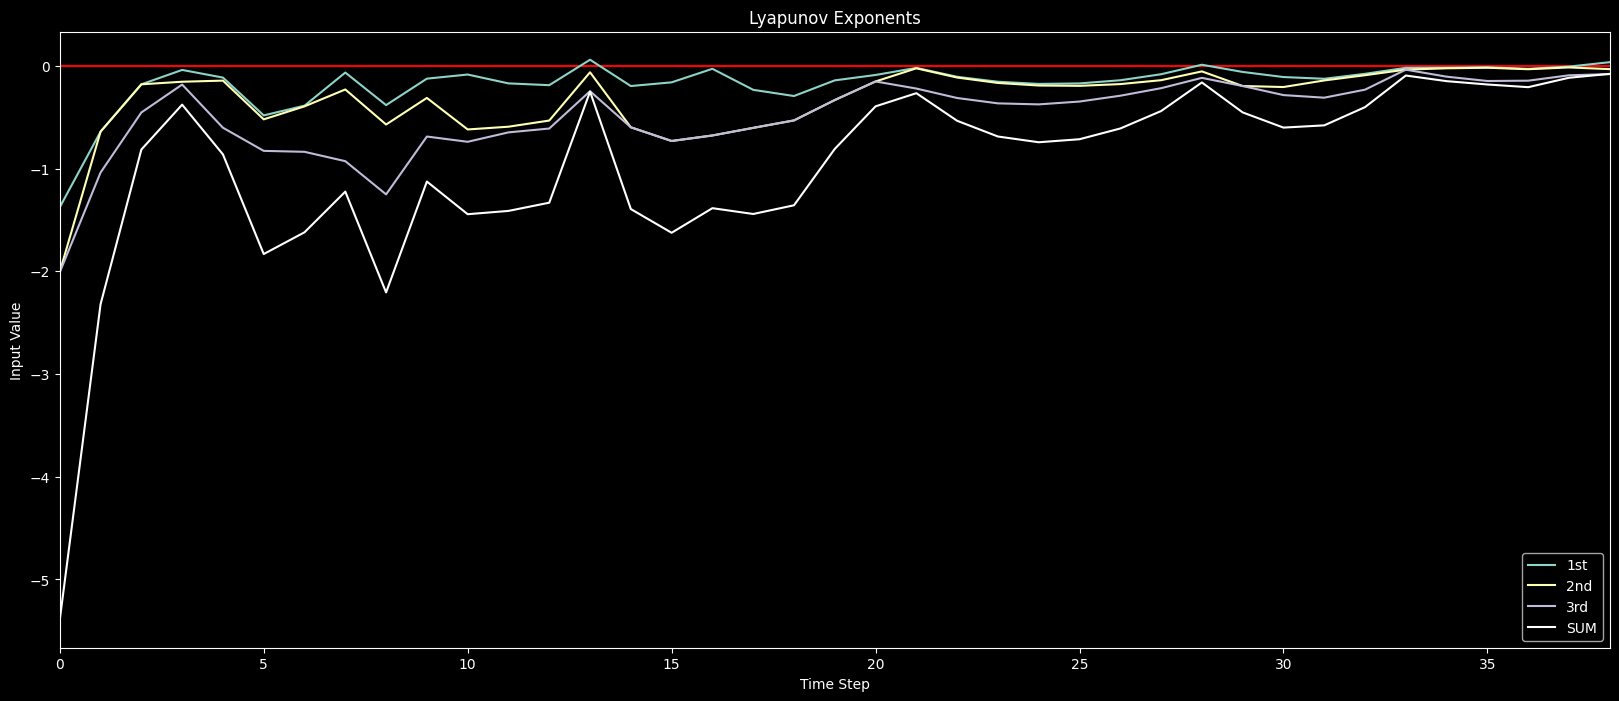

0.03510743
-0.03267419
-0.08097665


In [7]:
#---------------------------Lyapunov Plot---------------------------#

X = np.reshape(lyapunovs_list_mean.detach().numpy(), (epochs, input_size)).T

plt.style.use('dark_background') # Comment this line if you wish to have a white background

# Plot input trajectory
plt.figure(figsize=(20, 8))
plt.xlim(0, epoch)
plt.axhline(y = 0.0, color = 'r', linestyle = '-')  # specifying horizontal line type
plt.plot(X[0],'-', label='1st',alpha = 1)
plt.plot(X[1],'-', label='2nd',alpha = 1)
plt.plot(X[2],'-', label='3rd',alpha = 1)
#plt.plot(X[3],'.', label='4th',alpha = 1)
plt.plot(X[0] + X[1] + X[2],'-', label='SUM',alpha = 1, color = 'white', markersize = 12.0)
plt.axis('on') # You can choose to plot or not the axis
plt.xlabel('Time Step')
plt.ylabel('Input Value')
plt.title('Lyapunov Exponents')
plt.legend()
plt.show()
print(X[0,epoch])
print(X[1,epoch])
print(X[2,epoch])

In [31]:
#---------------------------3D scatter Plot For Final Lyapunov---------------------------#

# Initial condition
num_initial_conditions = 100
len_examples = 400
input_example_trajectory_list =[]

for j in range(num_initial_conditions):
  input_example = torch.rand((1, input_size)) 
  if i*j%100 ==0:
   print((j/num_initial_conditions)*100,'%')
  for i in range(len_examples):
      # Save the input vector to the trajectory
      if (i>39):
       input_example_trajectory_list.append(input_example.detach().numpy().squeeze())

      # Update the trajectory
      input_example = model(input_example)

#Convert input trajectory list to a numpy array
input_example_trajectory_array = np.array(input_example_trajectory_list)


# Normalize the sequence index to [0, 1] for colormap mapping
normalized_sequence_index = np.arange(len_examples * num_initial_conditions) / (len_examples * num_initial_conditions)



df = px.data.iris()
# Plot the 3D trajectory with color-coded points
fig = go.Figure(data=[go.Scatter3d(
    x=input_example_trajectory_array[:, 0],
    y=input_example_trajectory_array[:, 1],
    z=input_example_trajectory_array[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=normalized_sequence_index,                # set color to an array/list of desired values
        colorscale='sunset',   # choose a colorscale
        opacity=0.5
    )
)])

# Customize the layout and set the dark theme
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis'
    ),
    title='3D Scatter Plot',
    template='plotly_dark'  # Apply the dark theme
)

# Show the plot
fig.show()

#fig.savefig('my_plot.eps', dpi=300, format ='eps')
#fig.savefig('my_plot.pdf', dpi=300, format ='pdf')
fig.savefig('my_plot''.png', dpi=300, format ='png')

0.0 %


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
#---------------------------3D scatter Plot For Final Lyapunov---------------------------#

# Initial condition
num_initial_conditions = 1000
len_examples = 400
input_example_trajectory_list =[]

for j in range(num_initial_conditions):
  input_example = torch.rand((1, input_size)) * 12.0 - 6.0
  if i*j%100 ==0:
   print((j/num_initial_conditions)*100,'%')
  for i in range(len_examples):
      # Save the input vector to the trajectory
      if (i>0):
       input_example_trajectory_list.append(input_example.detach().numpy().squeeze())

      # Update the trajectory
      input_example = model(input_example)

#Convert input trajectory list to a numpy array
input_example_trajectory_array = np.array(input_example_trajectory_list)


# Normalize the sequence index to [0, 1] for colormap mapping
normalized_sequence_index = np.arange(len_examples * num_initial_conditions) / (len_examples * num_initial_conditions)

df = px.data.iris()
# Plot the 3D trajectory with color-coded points
fig = go.Figure(data=[go.Scatter3d(
    x=input_example_trajectory_array[:, 0],
    y=input_example_trajectory_array[:, 1],
    z=input_example_trajectory_array[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=normalized_sequence_index,                # set color to an array/list of desired values
        colorscale='Magma',   # choose a colorscale
        opacity=0.5
    )
)])

# Customize the layout and set the dark theme
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis'
    ),
    title='3D Scatter Plot',
    template='plotly_dark'  # Apply the dark theme
)

# Show the plot
fig.show()

#fig.savefig('my_plot.eps', dpi=300, format ='eps')
#fig.savefig('my_plot.pdf', dpi=300, format ='pdf')
#fig.savefig('my_plot.png', dpi=300, format ='png')

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
  #---------------------------Trajectories Plot---------------------------#

plt.style.use('dark_background') # Comment this line if you wish to have a white background

# Plot input trajectory
plt.figure(figsize=(20, 8))
plt.plot(input_trajectory_array[0:epoch*num_steps, 0],',', label='X',alpha = 0.5)
plt.plot(input_trajectory_array[0:epoch*num_steps, 1],',', label='Y',alpha = 0.5)
plt.plot(input_trajectory_array[0:epoch*num_steps, 2],',', label='Z',alpha = 0.5)

plt.axis('on') # You can choose to plot or not the axis
plt.xlabel('Time Step')
plt.ylabel('Input Value')
plt.title('Neural Chaos Attractors')
plt.legend()
plt.show()

In [ ]:
#---------------------------3D scatter Plot For Train Lyapunov---------------------------#

#Convert input trajectory list to a numpy array
input_trajectory_array = np.array(input_trajectory_list)


# Normalize the sequence index to [0, 1] for colormap mapping
normalized_sequence_index = np.arange(len(input_trajectory_array[:, 0])) / len(input_trajectory_array[:, 0])

df = px.data.iris()
# Plot the 3D trajectory with color-coded points
fig = go.Figure(data=[go.Scatter3d(
    x=input_trajectory_array[:, 0],
    y=input_trajectory_array[:, 1],
    z=input_trajectory_array[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=normalized_sequence_index,                # set color to an array/list of desired values
        colorscale='Magma',   # choose a colorscale
        opacity=1.0
    )
)])

# Customize the layout and set the dark theme
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis'
    ),
    title='3D Scatter Plot',
    template='plotly_dark'  # Apply the dark theme
)

# Show the plot
fig.show()

#fig.savefig('my_plot.eps', dpi=300, format ='eps')
#fig.savefig('my_plot.pdf', dpi=300, format ='pdf')
#fig.savefig('my_plot.png', dpi=300, format ='png')

In [ ]:
#---------------------------3D scatter Plot---------------------------#
# Convert input trajectory list to a numpy array
input_trajectory_array = np.array(input_trajectory_list)

# Create a colormap
cmap = cm.get_cmap('magma')  # You can choose a different colormap

# Normalize the sequence index to [0, 1] for colormap mapping
normalized_sequence_index = np.arange(len(input_example_trajectory_array[:, 0])) / len(input_example_trajectory_array[:, 0])

# Create a 3D plot
fig = plt.figure(figsize=plt.figaspect(1)*3.5, dpi=300) # Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect=(1, 1, 1))

# Plot the 3D trajectory with color-coded points
scatter = ax.scatter(
    input_example_trajectory_array[:, 0],
    input_example_trajectory_array[:, 1],
    input_example_trajectory_array[:, 2],
    c=normalized_sequence_index,  # Assign colors based on normalized sequence index
    cmap=cmap,
    marker=',',
    s=0.05,
    alpha =0.5,
    label='Trajectory'
)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis('off') # You can choose to plot or not the axis
ax.set_title('3D Trajectory Plot')


# Adjust the view angle (azimuthal angle and elevation angle)
ax.view_init(azim=100, elev=0)  # Adjust these angles as needed

# Add legend
ax.legend()

# Show the plot
plt.show()
#fig.savefig('my_plot.eps', dpi=300, format ='eps')
#fig.savefig('my_plot.pdf', dpi=300, format ='pdf')
fig.savefig('my_plot.png', dpi=300, format ='png')

In [ ]:
#---------------------------2D Scatter Plot---------------------------#

# Normalize the sequence index to [0, 1] for colormap mapping
normalized_sequence_index = np.arange(len(input_trajectory_array[:, 0])) / len(input_trajectory_array[:, 0])

# Create a 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    input_trajectory_array[:, 0],  # X-axis
    input_trajectory_array[:, 2],  # Y-axis
    c=normalized_sequence_index,  # Color of the points
    marker=',', # Marker style
    s = 0.9, # Marker size
    cmap = 'viridis',
    label='Trajectory'
)

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('on') # You can choose to plot or not the axis
plt.title('2D Trajectory Scatter Plot')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()